Натренувати класифікатори на датасеті
https://archive.ics.uci.edu/dataset/713/auction+verification
Мають бути 3 варіанти класифікаторів (стекінг, бустінг, беггінг)

*   первинний аналіз даних (відстуність пропусків, наявність категоріальних фіч, duplicated, Nan) (+)
*   фича інжиніринг (побудувати 1-2 нові фічі) (+)
*   Убрать кореляцію в фічах (+)
*   поділ датасету на train, validate, test (+ random_state) (+)
*   GridSearchCV (+)
*   Scaling (+)
*   тренування базової моделі із дефолтними гіперпараметрами (кожну модель) (+)
*   підбір гіперпараметрів (кожну модель) (+)
*   побудувати модель різними способами (+)
*   Metrics (+)
*   оцінка результатів (порівняння всіх на тестовій частині, описати яка краще) (+)
*  Графічний аналіз, (якщо встигну)

## INIT BLOCK

### Import Requirements

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from matplotlib.axes import Axes
from matplotlib.container import BarContainer
from pandas.core.arrays.sparse.array import NaT
from pandas.core.groupby import DataFrameGroupBy
from sklearn.linear_model import (LinearRegression, SGDRegressor, ElasticNet, Lasso, LogisticRegression, Perceptron, RidgeClassifier, SGDClassifier,
                                  Ridge,)
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error, accuracy_score, classification_report, precision_recall_curve,
                             precision_score, recall_score, f1_score, roc_auc_score)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold, SelectFromModel
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, AdaBoostClassifier, VotingClassifier, AdaBoostRegressor,
                              StackingClassifier, StackingRegressor)
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import ADASYN, BorderlineSMOTE, KMeansSMOTE, SMOTENC, SVMSMOTE


### Init

In [ ]:
RANDOM_STATE: int = 1729


def mount_google_drive() -> bool | None:
    """
    Function to mount Google Drive.
    :return: True if mounting is successful, None otherwise.
    """
    try:
        from google.colab.drive import mount

        mount(mountpoint="/content/drive")
        return True

    except Exception as error:
        print(f"Error while mounting Google Drive: {error}")
        raise


def get_data_frame(dataset_path: str, *args, sep: str = ",", **kwargs) -> pd.DataFrame | None:
    """
    Function to convert the dataset into a pd.DataFrame.
    :param sep: Separator for csv data, default - ",".
    :param dataset_path: Path or URL of the dataset.
    :return: pd.DataFrame containing the dataset, or None if errors occur.
    """
    try:
        return pd.read_csv(filepath_or_buffer=dataset_path, sep=sep, **kwargs)

    except Exception as error:
        print(f"Error while converting dataset to NumPy array: {error}")
        raise


def main(dataset_path: str, *args, **kwargs) -> pd.DataFrame | None:
    """
    Main function to start the app.
    :return: pd.DataFrame containing the dataset, or None if errors occur.
    """
    if mount_google_drive():
        import os

        if os.path.exists(path=dataset_path):
            return get_data_frame(dataset_path=dataset_path, *args, **kwargs)

        else:
            print("Dataset path doesn't exists.")
            raise FileNotFoundError


if __name__ == "__main__":
    auction_verification_dataframe: pd.DataFrame | None = main(dataset_path="/content/drive/MyDrive/Hillel/Machine_Learning_Course/HW9/data.csv")

    if isinstance(auction_verification_dataframe, pd.DataFrame):
        working_dataframe: pd.DataFrame = auction_verification_dataframe.copy()  # TODO rename this variable according to dataset name

        target: list = ["verification.result", "verification.time"]
        features: list = ["process.b1.capacity", "process.b2.capacity", "process.b3.capacity", "process.b4.capacity", "property.price", "property.product", "property.winner"]

        # headers: list = features_names + target_column_name


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data analysis, clining and optomization

### Перевіряємо на дублікати

In [ ]:
print(f"{'Є дублікати, потрібна обробка датасету.' if working_dataframe.duplicated().sum() else 'Дублікатів немає.'}", end="\n\n")

Дублікатів немає.



### Обробка відсутніх значеннь

In [ ]:
print(f"{'Є пропущені значення, потрібна обробка датасету.' if working_dataframe.isna().any().any() else 'Пропущених значень немає.'}", end="\n\n")
working_dataframe.info()
working_dataframe.head()

Пропущених значень немає.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   process.b1.capacity  2043 non-null   int64  
 1   process.b2.capacity  2043 non-null   int64  
 2   process.b3.capacity  2043 non-null   int64  
 3   process.b4.capacity  2043 non-null   int64  
 4   property.price       2043 non-null   int64  
 5   property.product     2043 non-null   int64  
 6   property.winner      2043 non-null   int64  
 7   verification.result  2043 non-null   bool   
 8   verification.time    2043 non-null   float64
dtypes: bool(1), float64(1), int64(7)
memory usage: 129.8 KB


,process.b1.capacity,process.b2.capacity,process.b3.capacity,process.b4.capacity,property.price,property.product,property.winner,verification.result,verification.time
0,0,0,2,1,59,1,0,False,163.316667
1,0,0,2,1,59,2,0,False,200.860000
2,0,0,2,1,59,4,0,False,154.888889
3,0,0,2,1,59,6,0,False,108.640000
4,0,0,2,1,60,1,0,True,85.466667


### Замінемо категорії таргета на числа, де "True" == 1, "False" == 0:

In [ ]:
bool_target_column: str = target[0]
working_dataframe[bool_target_column]: pd.Series = working_dataframe[bool_target_column].replace(to_replace={False: 0, True: 1})

working_dataframe.info()
working_dataframe.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   process.b1.capacity  2043 non-null   int64  
 1   process.b2.capacity  2043 non-null   int64  
 2   process.b3.capacity  2043 non-null   int64  
 3   process.b4.capacity  2043 non-null   int64  
 4   property.price       2043 non-null   int64  
 5   property.product     2043 non-null   int64  
 6   property.winner      2043 non-null   int64  
 7   verification.result  2043 non-null   int64  
 8   verification.time    2043 non-null   float64
dtypes: float64(1), int64(8)
memory usage: 143.8 KB


,process.b1.capacity,process.b2.capacity,process.b3.capacity,process.b4.capacity,property.price,property.product,property.winner,verification.result,verification.time
0,0,0,2,1,59,1,0,0,163.316667
1,0,0,2,1,59,2,0,0,200.860000
2,0,0,2,1,59,4,0,0,154.888889
3,0,0,2,1,59,6,0,0,108.640000
4,0,0,2,1,60,1,0,1,85.466667
5,0,0,2,1,60,1,3,1,82.000000
6,0,0,2,1,60,1,4,0,154.250000
7,0,0,2,1,60,2,0,1,80.950000
8,0,0,2,1,60,2,3,1,78.000000
9,0,0,2,1,60,2,4,0,197.010000


### Генеруємо статистику

In [ ]:
working_dataframe.describe(include="all", percentiles=[.25, .5, .75])

,process.b1.capacity,process.b2.capacity,process.b3.capacity,process.b4.capacity,property.price,property.product,property.winner,verification.result,verification.time
count,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000
mean,1.000000,2.093979,1.883994,0.587861,71.473324,3.252080,0.455213,0.128243,7336.944574
std,0.816696,0.811269,0.320310,0.492340,8.048740,1.804225,1.062828,0.334442,10375.393650
min,0.000000,0.000000,1.000000,0.000000,59.000000,1.000000,0.000000,0.000000,77.916667
25%,0.000000,1.000000,2.000000,0.000000,65.000000,2.000000,0.000000,0.000000,546.818910
50%,1.000000,2.000000,2.000000,1.000000,70.000000,3.000000,0.000000,0.000000,1316.983333
75%,2.000000,3.000000,2.000000,1.000000,78.000000,5.000000,0.000000,0.000000,10876.638889
max,2.000000,3.000000,2.000000,1.000000,90.000000,6.000000,4.000000,1.000000,44130.520833


# Feature Engineering

### Візуалізація даних

<Axes: >

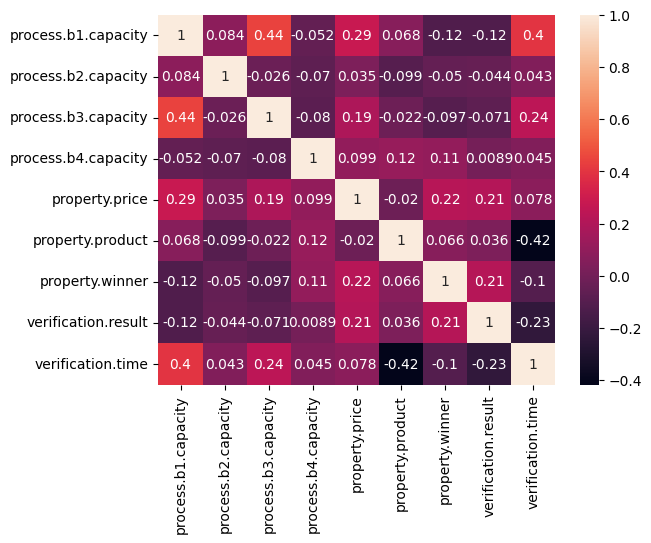

In [ ]:
working_dataframe_corr_matrix = working_dataframe.corr()  # full heatmap
sns.heatmap(data=working_dataframe_corr_matrix, annot=True)

Кореляції між фічами немає, також немає кореляції фіч до таргетів.

### Додаємо нові фічі

<Axes: >

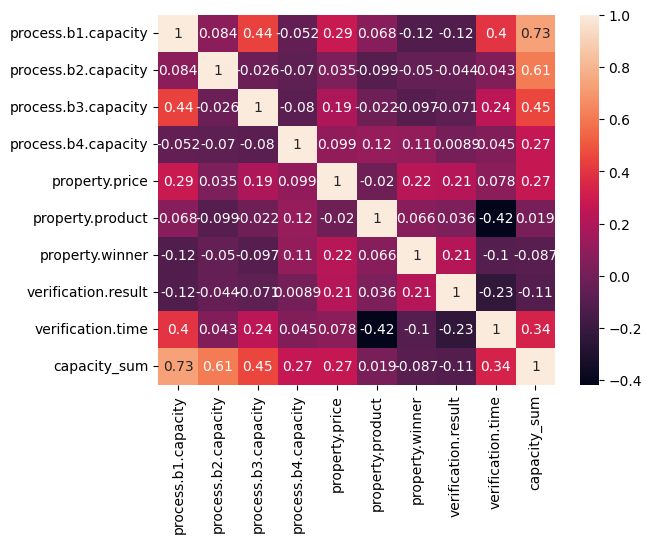

In [ ]:
working_dataframe["capacity_sum"]: pd.Series = working_dataframe["process.b1.capacity"] + working_dataframe["process.b2.capacity"] + working_dataframe["process.b3.capacity"] + working_dataframe["process.b4.capacity"]

working_dataframe_corr_matrix = working_dataframe.corr()  # full heatmap
sns.heatmap(data=working_dataframe_corr_matrix, annot=True)

# Preparing data for training

### Розбиваємо датасет на фічі та таргет

In [ ]:
x_features: pd.DataFrame = working_dataframe.copy().drop(target, axis=1)
y_target: pd.DataFrame = working_dataframe[target]

### Масштабування фічів

In [ ]:
x_scaled: np.ndarray = x_features

### Розбиваємо дані на тренувальну, валідаційну та тестову частину

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_target, test_size=0.33, random_state=RANDOM_STATE, stratify=y_target["verification.result"])
x_validate, x_test, y_validate, y_test = train_test_split(x_test, y_test, test_size=0.33, random_state=RANDOM_STATE, stratify=y_test["verification.result"])

y_validate_cls, y_validate_regres = y_validate["verification.result"], y_validate["verification.time"]
y_test_cls, y_test_regres = y_test["verification.result"], y_test["verification.time"]

print(x_train.shape)
print(x_validate.shape)
print(x_test.shape)

(1368, 8)
(452, 8)
(223, 8)


### Балансування классів

In [ ]:
# x_resampled, y_resampled = x_train, y_train
x_resampled, y_resampled_cls, y_resampled_regres = x_train, y_train["verification.result"], y_train["verification.time"]

# FIT PREDICT

## Functions for fit models, make predict and generate metrics

In [ ]:
def print_model_name(name: str) -> None:
    print("'" * 60)
    print(f"MODEL: {name}")

In [ ]:
def value_results_main(predict, y_test):
    accuracy = accuracy_score(y_true=y_test, y_pred=predict)
    precision = precision_score(y_true=y_test, y_pred=predict, average="micro")
    recall = recall_score(y_true=y_test, y_pred=predict, average="micro")
    f1 = f1_score(y_true=y_test, y_pred=predict, average="micro")

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

In [ ]:
def value_regression(predict, y_test):
    model_r2: np.float64 = r2_score(y_true=y_test, y_pred=predict)
    model_mean_squared_error: np.float64 = mean_squared_error(y_true=y_test, y_pred=predict)
    model_mean_absolute_error: np.float64 = mean_absolute_error(y_true=y_test, y_pred=predict)

    print(f"R2:                         {model_r2}")
    print(f"Mean_squared_error (MSE):   {model_mean_squared_error}")
    print(f"Mean_absolute_error (MAE):  {model_mean_absolute_error}")

In [ ]:
def value_results(name:str, predict, y_test):
    print_model_name(name=name)
    try:
      value_results_main(predict=predict, y_test=y_test)
    except ValueError:
      value_regression(predict=predict, y_test=y_test)

    print("'" * 60)

In [ ]:
# def train_model(model_class, name: str, grid_params=None, y_train=y_resampled): default
def train_model(model_class, name: str, y_train, y_validate, grid_params=None):
    print_model_name(name=name)

    if grid_params:
        model: GridSearchCV = GridSearchCV(estimator=model_class, param_grid=grid_params).fit(X=x_resampled, y=y_train)

        print("Best params: ", model.best_params_)
        print("Best score: ", model.best_score_)

    else:
        model = model_class.fit(X=x_resampled, y=y_train)

    y_pred = model.predict(X=x_validate)

    try:
        print(f"Classification report:\n{classification_report(y_true=y_validate, y_pred=y_pred)}")
        value_results_main(predict=y_pred, y_test=y_validate)

    except ValueError:
        value_regression(predict=y_pred, y_test=y_validate)

    return model


## Тренуємо моделі

### Bagging

In [ ]:
## RandomForestClassifier() with default hyperparams
model_random_forest_classifier: RandomForestClassifier = train_model(model_class=RandomForestClassifier(), y_train=y_resampled_cls,
                                                                     y_validate=y_validate_cls, name="RandomForestClassifier with default hyperparameters")

''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
MODEL: RandomForestClassifier with default hyperparameters
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       394
           1       0.96      0.74      0.83        58

    accuracy                           0.96       452
   macro avg       0.96      0.87      0.91       452
weighted avg       0.96      0.96      0.96       452

Accuracy: 0.9623893805309734
Precision: 0.9623893805309734
Recall: 0.9623893805309734
F1 Score: 0.9623893805309734


In [ ]:
## RandomForestClassifier() з підбіром параметрів через GridSearchCV
grid_random_forest_clasifier_params = {
        "n_estimators": [100],  # default=100
        "criterion": ["entropy"],  # ["gini", "entropy", "log_loss"], default=”gini”
        "max_depth": [None],  # int, default=None
        "min_samples_split": [2],  # int or float, default=2
        "min_samples_leaf": [1],  # int or float, default=1
        "min_weight_fraction_leaf": [0.0,],  # loat, default=0.0
        "max_features": [None],  # {“sqrt”, “log2”, None}, int or float, default=”sqrt”
        "max_leaf_nodes": [None],  # int, default=None
        "min_impurity_decrease": [0.0],  # float, default=0.0
        "bootstrap": [True],  # bool, default=True
        "oob_score": [True],  # bool or callable, default=False
        "n_jobs": [None],  # int, default=None
        "random_state": [RANDOM_STATE],  # int, RandomState instance or None, default=None
        "verbose": [0],  # int, default=0
        "warm_start": [False],  # bool, default=False
        "class_weight": [None],  # ["balanced_subsample", "balanced", None], dict or list of dicts, default=None
        "ccp_alpha": [0.0],  # non-negative float, default=0.0
        "max_samples": [None]  # int or float, default=None (number of rows)
}
model_random_forest_classifier_grid = train_model(model_class=RandomForestClassifier(), y_train=y_resampled_cls, y_validate=y_validate_cls,
                                                  name="RandomForestClassifier with Grid hyperparameters", grid_params=grid_random_forest_clasifier_params)

''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
MODEL: RandomForestClassifier with Grid hyperparameters
Best params:  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': True, 'random_state': 1729, 'verbose': 0, 'warm_start': False}
Best score:  0.9839202160370043
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       394
           1       1.00      0.98      0.99        58

    accuracy                           1.00       452
   macro avg       1.00      0.99      1.00       452
weighted avg       1.00      1.00      1.00       452

Accuracy: 0.9977876106194691
Precision: 0.9977876106194691
Recall: 0.9977876106194691
F1 Score

In [ ]:
## RandomForestRegressor() with default hyperparams
model_random_forest_regressor: RandomForestRegressor = train_model(model_class=RandomForestRegressor(), y_train=y_resampled_cls,
                                                                     y_validate=y_validate_cls, name="RandomForestRegressor with default hyperparameters")

''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
MODEL: RandomForestRegressor with default hyperparameters
R2:                         0.9456520042009452
Mean_squared_error (MSE):   0.006078982300884956
Mean_absolute_error (MAE):  0.017411504424778762


In [ ]:
## RandomForestRegressor() з підбіром параметрів через GridSearchCV
grid_g_boost_clasifier_params = {
        "n_estimators": [100],  # default=100
        "criterion": ["squared_error"],  # ["squared_error", "absolute_error", "friedman_mse", "poisson"], default=”squared_error”
        "max_depth": [None],  # int, default=None
        "min_samples_split": [2],  # int or float, default=2
        "min_samples_leaf": [1],  # int or float, default=1
        "min_weight_fraction_leaf": [0.0,],  # loat, default=0.0
        "max_features": [None],  # {“sqrt”, “log2”, None}, int or float, default=1.0
        "max_leaf_nodes": [None],  # int, default=None
        "min_impurity_decrease": [0.0],  # float, default=0.0
        "bootstrap": [True],  # bool, default=True
        "oob_score": [True],  # bool or callable, default=False
        "n_jobs": [None],  # int, default=None
        "random_state": [RANDOM_STATE,],  # int, RandomState instance or None, default=None
        "verbose": [0],  # int, default=0
        "warm_start": [False],  # bool, default=False
        "ccp_alpha": [0.0],  # non-negative float, default=0.0
        "max_samples": [None]  # int or float, default=None (number of rows)
}
model_random_forest_regressor_grid = train_model(model_class=RandomForestRegressor(), y_train=y_resampled_cls, y_validate=y_validate_cls,
                                                  name="RandomForestRegressor with Grid hyperparameters", grid_params=grid_g_boost_clasifier_params)

''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
MODEL: RandomForestRegressor with Grid hyperparameters
Best params:  {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': True, 'random_state': 1729, 'verbose': 0, 'warm_start': False}
Best score:  0.876778992233399
R2:                         0.9597982671100997
Mean_squared_error (MSE):   0.004496681415929203
Mean_absolute_error (MAE):  0.016039823008849558


### Boosting

In [ ]:
## AdaBoostClassifier() with default hyperparams
model_ada_boost_classifier: AdaBoostClassifier = train_model(model_class=AdaBoostClassifier(), y_train=y_resampled_cls,
                                                                     y_validate=y_validate_cls, name="AdaBoostClassifier with default hyperparameters")

''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
MODEL: AdaBoostClassifier with default hyperparameters
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       394
           1       0.88      0.62      0.73        58

    accuracy                           0.94       452
   macro avg       0.91      0.80      0.85       452
weighted avg       0.94      0.94      0.94       452

Accuracy: 0.9402654867256637
Precision: 0.9402654867256637
Recall: 0.9402654867256637
F1 Score: 0.9402654867256637


In [ ]:
## AdaBoostClassifier() з підбіром параметрів через GridSearchCV
grid_ada_boost_clasifier_params = {
        # "estimator": [DecisionTreeClassifier(), RandomForestClassifier(), model_random_forest_classifier_grid],  # object, default=None
        "estimator": [DecisionTreeClassifier()],  # object, default=None
        "n_estimators": [100],  # int default=50
        "learning_rate": [1.0],  # float, default=1.0
        "algorithm": ["SAMME"],  # {‘SAMME’, ‘SAMME.R’}, default=’SAMME.R’
        "random_state": [RANDOM_STATE],  # int, RandomState instance or None, default=None
}
model_ada_boost_classifier_grid = train_model(model_class=AdaBoostClassifier(), y_train=y_resampled_cls, y_validate=y_validate_cls,
                                                  name="AdaBoostClassifier with Grid hyperparameters", grid_params=grid_ada_boost_clasifier_params)

''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
MODEL: AdaBoostClassifier with Grid hyperparameters
Best params:  {'algorithm': 'SAMME', 'estimator': DecisionTreeClassifier(), 'learning_rate': 1.0, 'n_estimators': 100, 'random_state': 1729}
Best score:  0.9773321568942007
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       394
           1       1.00      0.98      0.99        58

    accuracy                           1.00       452
   macro avg       1.00      0.99      1.00       452
weighted avg       1.00      1.00      1.00       452

Accuracy: 0.9977876106194691
Precision: 0.9977876106194691
Recall: 0.9977876106194691
F1 Score: 0.9977876106194691


In [ ]:
## AdaBoostRegressor() with default hyperparams
model_ada_boost_regressor: AdaBoostRegressor = train_model(model_class=AdaBoostRegressor(), y_train=y_resampled_cls,
                                                           y_validate=y_validate_cls, name="AdaBoostRegressor with default hyperparameters")

''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
MODEL: AdaBoostRegressor with default hyperparameters
R2:                         0.4624744277865591
Mean_squared_error (MSE):   0.060123807542786976
Mean_absolute_error (MAE):  0.17440987225739016


In [ ]:
## AdaBoostRegressor() з підбіром параметрів через GridSearchCV
grid_ada_boost_regressor_params = {
        # "estimator": [DecisionTreeClassifier(),  RandomForestRegressor(),],  # object, default=None
        "estimator": [DecisionTreeRegressor()],  # object, default=None
        "n_estimators": [94],  # int default=50
        "learning_rate": [1.5,],  # float, default=1.0
        "loss": ["exponential"],  # "linear", "square", "exponential", default=’linear’
        "random_state": [RANDOM_STATE],  # int, RandomState instance or None, default=None
}
model_ada_boost_regressor_grid = train_model(model_class=AdaBoostRegressor(), y_train=y_resampled_cls, y_validate=y_validate_cls,
                                             name="AdaBoostRegressor with Grid hyperparameters", grid_params=grid_ada_boost_regressor_params)

''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
MODEL: AdaBoostRegressor with Grid hyperparameters
Best params:  {'estimator': DecisionTreeRegressor(), 'learning_rate': 1.5, 'loss': 'exponential', 'n_estimators': 94, 'random_state': 1729}
Best score:  0.8966869654209806
Classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       394
           1       1.00      0.97      0.98        58

    accuracy                           1.00       452
   macro avg       1.00      0.98      0.99       452
weighted avg       1.00      1.00      1.00       452

Accuracy: 0.995575221238938
Precision: 0.995575221238938
Recall: 0.995575221238938
F1 Score: 0.995575221238938


### Stacking

In [ ]:
stacking_regressor_estimators: list = [
    ("model_random_forest_regressor", model_random_forest_regressor),
    ("model_random_forest_regressor_grid", model_random_forest_regressor_grid.best_estimator_),
    ("model_ada_boost_regressor", model_ada_boost_regressor),
    ("model_ada_boost_regressor_grid", model_ada_boost_regressor_grid.best_estimator_)
]

In [ ]:
stacking_classifier_estimators: list = [
    ("model_random_forest_classifier", model_random_forest_classifier),
    ("model_random_forest_classifier_grid", model_random_forest_classifier_grid.best_estimator_),
    ("model_ada_boost_classifier", model_ada_boost_classifier),
    ("model_ada_boost_classifier_grid", model_ada_boost_classifier_grid.best_estimator_),
] + stacking_regressor_estimators

In [ ]:
## StackingClassifier() with default hyperparams
model_stacking_clasifier: StackingClassifier = train_model(model_class=StackingClassifier(estimators=stacking_classifier_estimators), y_train=y_resampled_cls,
                                                           y_validate=y_validate_cls, name="StackingClassifier with default hyperparameters")

''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
MODEL: StackingClassifier with default hyperparameters
Classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       394
           1       1.00      0.97      0.98        58

    accuracy                           1.00       452
   macro avg       1.00      0.98      0.99       452
weighted avg       1.00      1.00      1.00       452

Accuracy: 0.995575221238938
Precision: 0.995575221238938
Recall: 0.995575221238938
F1 Score: 0.995575221238938


In [ ]:
## StackingClassifier() з підбіром параметрів через GridSearchCV
grid_model_stacking_clasifier_params = {
        "estimators": [stacking_classifier_estimators],  # list of (str, estimator)
        # "final_estimator": [None, Perceptron, RidgeClassifier, SGDClassifier],  # estimator, default=None,  BEST None
        "final_estimator": [None],
        "cv": [None],  # int, cross-validation generator, iterable, or “prefit”, default=None
        "stack_method": ["predict"],  # ["auto", "predict_proba", "decision_function", "predict"] default=’auto’
        "n_jobs": [None, ],  # int, default=None
        "passthrough": [True],  # bool, default=False
        "verbose": [0] # int, default=0
}
model_stacking_clasifier_grid = train_model(model_class=StackingClassifier(estimators=stacking_classifier_estimators), y_train=y_resampled_cls, y_validate=y_validate_cls,
                                             name="StackingClassifier with Grid hyperparameters", grid_params=grid_model_stacking_clasifier_params)

''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
MODEL: StackingClassifier with Grid hyperparameters


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best params:  {'cv': None, 'estimators': [('model_random_forest_classifier', RandomForestClassifier()), ('model_random_forest_classifier_grid', RandomForestClassifier(criterion='entropy', max_features=None, oob_score=True,
                       random_state=1729)), ('model_ada_boost_classifier', AdaBoostClassifier()), ('model_ada_boost_classifier_grid', AdaBoostClassifier(algorithm='SAMME', estimator=DecisionTreeClassifier(),
                   n_estimators=100, random_state=1729)), ('model_random_forest_regressor', RandomForestRegressor()), ('model_random_forest_regressor_grid', RandomForestRegressor(max_features=None, oob_score=True, random_state=1729)), ('model_ada_boost_regressor', AdaBoostRegressor()), ('model_ada_boost_regressor_grid', AdaBoostRegressor(estimator=DecisionTreeRegressor(), learning_rate=1.5,
                  loss='exponential', n_estimators=94, random_state=1729))], 'final_estimator': None, 'n_jobs': None, 'passthrough': True, 'stack_method': 'predict', 'verbose'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
## StackingRegressor() with default hyperparams
model_stacking_regressor: StackingRegressor = train_model(model_class=StackingRegressor(stacking_regressor_estimators), y_train=y_resampled_cls,
                                                           y_validate=y_validate_cls, name="StackingRegressor with default hyperparameters")

''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
MODEL: StackingRegressor with default hyperparameters
R2:                         0.9681260816766399
Mean_squared_error (MSE):   0.0035651909973638445
Mean_absolute_error (MAE):  0.011021278457759189


In [ ]:
## StackingRegressor() з підбіром параметрів через GridSearchCV
grid_model_stacking_regressor_params = {
        "estimators": [stacking_regressor_estimators],  # list of (str, estimator)
        # "final_estimator": [None, LinearRegression, SGDRegressor, ElasticNet, Lasso, LogisticRegression, Ridge],  # estimator, default=None, BEST: None
        "final_estimator": [None],
        "cv": [None,],  # int, cross-validation generator, iterable, or "prefit", default=None
        "n_jobs": [None],  # int, default=None
        "passthrough": [False],  # bool, default=False
        "verbose": [0] # int, default=0
}
model_stacking_regressor_grid = train_model(model_class=StackingRegressor(estimators=stacking_regressor_estimators), y_train=y_resampled_cls, y_validate=y_validate_cls,
                                             name="StackingRegressor with Grid hyperparameters", grid_params=grid_model_stacking_regressor_params)

''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
MODEL: StackingRegressor with Grid hyperparameters
Best params:  {'cv': None, 'estimators': [('model_random_forest_regressor', RandomForestRegressor()), ('model_random_forest_regressor_grid', RandomForestRegressor(max_features=None, oob_score=True, random_state=1729)), ('model_ada_boost_regressor', AdaBoostRegressor()), ('model_ada_boost_regressor_grid', AdaBoostRegressor(estimator=DecisionTreeRegressor(), learning_rate=1.5,
                  loss='exponential', n_estimators=94, random_state=1729))], 'final_estimator': None, 'n_jobs': None, 'passthrough': False, 'verbose': 0}
Best score:  0.8972427265254952
R2:                         0.9704539626769841
Mean_squared_error (MSE):   0.003304810698300363
Mean_absolute_error (MAE):  0.010314190355175256


## Порівняння результатів

In [ ]:
value_results(name="RandomForestClassifier with default hyperparameters",
              predict=model_random_forest_classifier.predict(X=x_test), y_test=y_test_cls)

value_results(name="RandomForestClassifier with Grid hyperparameters",
              predict=model_random_forest_classifier_grid.predict(X=x_test), y_test=y_test_cls)

value_results(name="RandomForestRegressor with default hyperparameters",
              predict=model_random_forest_regressor.predict(X=x_test), y_test=y_test_cls)

value_results(name="RandomForestRegressor with Grid hyperparameters",
              predict=model_random_forest_regressor_grid.predict(X=x_test), y_test=y_test_cls)

value_results(name="AdaBoostClassifier with default hyperparameters",
              predict=model_ada_boost_classifier.predict(X=x_test), y_test=y_test_cls)

value_results(name="AdaBoostClassifier with Grid hyperparameters",
              predict=model_ada_boost_classifier_grid.predict(X=x_test), y_test=y_test_cls)

value_results(name="AdaBoostRegressor with default hyperparameters",
              predict=model_ada_boost_regressor.predict(X=x_test), y_test=y_test_cls)

value_results(name="AdaBoostRegressor with Grid hyperparameters",
              predict=model_ada_boost_regressor_grid.predict(X=x_test), y_test=y_test_cls)

value_results(name="StackingClassifier with default hyperparameters",
              predict=model_stacking_clasifier.predict(X=x_test), y_test=y_test_cls)

value_results(name="StackingClassifier with Grid hyperparameters",
              predict=model_stacking_clasifier_grid.predict(X=x_test), y_test=y_test_cls)

value_results(name="StackingRegressor with default hyperparameters",
              predict=model_stacking_regressor.predict(X=x_test), y_test=y_test_cls)

value_results(name="StackingRegressor with Grid hyperparameters",
              predict=model_stacking_regressor_grid.predict(X=x_test), y_test=y_test_cls)

''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
MODEL: RandomForestClassifier with default hyperparameters
Accuracy: 0.9551569506726457
Precision: 0.9551569506726457
Recall: 0.9551569506726457
F1 Score: 0.9551569506726457
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
MODEL: RandomForestClassifier with Grid hyperparameters
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
MODEL: RandomForestRegressor with default hyperparameters
R2:                         0.9652578208318521
Mean_squared_error (MSE):   0.003930493273542601
Mean_absolute_error (MAE):  0.017623318385650226
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
MODEL: RandomForestRegressor with Grid hyperparameters
R2:                         0.

# Висновок

Провів тести на 6 різних моделях з дефолтними гіперпараметрами + ті самі 6 з підібраними гіперпараметрами через GridSearch. З них 3 класифікатора та 3 регресора.

**Балансування** класів не робив, тому що в цьому не було критичної необхідності, моделі і без того показують максимальний результат.

**Масштабування** також не проводив, тому що в датасеті немає великого розбігу в фічах. Всі дані знаходяться в диапазоні від 0 до 100

З класифікаторів, найкращі, стабільні, та МАКСИМАЛЬНІ (f1 score = 1) результати показали 4 з 6 моделей:
1. RandomForestClassifier with Grid hyperparameters
2. AdaBoostClassifier with Grid hyperparameters
3. StackingClassifier with default hyperparameters
4. StackingClassifier with Grid hyperparameters

З регресорів найбільшого результату (R2 = 0.995, MSE та MAE ~ 0) досягли такі моделі, з різницею в тисячних долях:
1. StackingRegressor with default hyperparameters
2. StackingRegressor with Grid hyperparameters

Варто відмітити що всі моделі "StackingClassifier" та "StackingRegressor" базуються на попередньо навчених вище моделях RandomForest та AdaBoost.

Також, як можна побачити з тестів, майже завжди кращий результат показують моделі з "підігнаними" гіперпараметрами, так як дефолтні не можуть завжди підходити до будь-якого датасету. Варто завжди приділяти цьому увагу.